In [1]:
import pandas as pd
import pypsa
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import ipynb
import os
from os import walk
import plotly.express as px
import json
import plotly.graph_objs as gobj
import plotly.graph_objects as go

In [2]:
def load_data(mypath1,filenames):
    networks = {}
    planning_horizon = []
    for file in filenames:
        year = file[-7:-3]
        print("Loading year {} ".format(year))
        networks[year] = pypsa.Network(os.path.join(mypath1,file))
        planning_horizon.append(year)
    print("I have done my deed now set me Free, mortal!")
    return(networks, planning_horizon)

In [3]:
def get_grid_df(n,carrier):
    """Gets all capacity dataframes for the grid
    Parameters
    ----------
    n : Networks
    carrier : string (== "gas pipeline", "AC", "H2 pipeline")
        carrier (e.g. "gas pipeline", "DC") used in lines and links for transporting a specific energy
    
    Returns
    -------
    two dataframes:
    normal = classic grid, including newly build H2 grid
    retro only used for H2 retrofitted piplines.
    """
    normal = n.copy()
    retro = n.copy()
    dc = n.copy()
    if carrier == 'AC':
        normal.lines = n.lines[n.lines.type =="Al/St 240/40 4-bundle 380.0"]
        dc.links = n.links[n.links.carrier == "DC"]
        for bus in normal.buses[n.buses.carrier=="AC"].index:
            dc.buses.loc[f"{bus}", ["x","y"]] = normal.buses.loc[bus, ["x","y"]]
    else: 
        normal.links = n.links[(n.links.carrier == carrier)]
        carrier_retro = carrier + " retrofit"
        retro.links = n.links[(n.links.carrier == carrier_retro)]
        for bus in normal.buses[n.buses.carrier=="AC"].index:
            normal.buses.loc[f"{bus}"+ " "  + carrier[:3].strip(), ["x","y"]] = normal.buses.loc[bus, ["x","y"]]
            retro.buses.loc[f"{bus}"+ " " + carrier[:3].strip(), ["x","y"]] = retro.buses.loc[bus, ["x","y"]]
    return(normal,retro,dc)

In [4]:
countries = gpd.read_file(r'C:\Users\johannes.misensky\OneDrive - AGGM\Dokumente\pyp\Shapefile\shape_nuts2.shp')


In [5]:
mypath = r"C:\Users\johannes.misensky\OneDrive - AGGM\Dokumente\ESM_Aus\postnetworks\test_1"
mypath1 = f"{mypath}"
filenames = next(walk(mypath1), (None, None, []))[2]

networks = {}
planning_horizon = []
filenames

networks, planning_horizon = load_data(mypath1,filenames)

Loading year 2015 


Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 17, 1].

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network elec_s_AT10_lv1.0__Co2L0p79-120H-T-H-B-I_2015.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading year 2020 


Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 17, 1].

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network elec_s_AT10_lv1.0__Co2L0p79-120H-T-H-B-I_2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading year 2030 


Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 17, 1].

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network elec_s_AT10_lv1.0__Co2L0p79-120H-T-H-B-I_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading year 2040 


Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 17, 1].

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network elec_s_AT10_lv1.0__Co2L0p79-120H-T-H-B-I_2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading year 2050 


Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 17, 1].

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network elec_s_AT10_lv1.0__Co2L0p79-120H-T-H-B-I_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


I have done my deed now set me Free, mortal!


In [6]:
#countries.to_file("path_to_GeoJSON _file", driver = "GeoJSON")
with open("path_to_GeoJSON _file") as geofile:
    j_file = json.load(geofile)

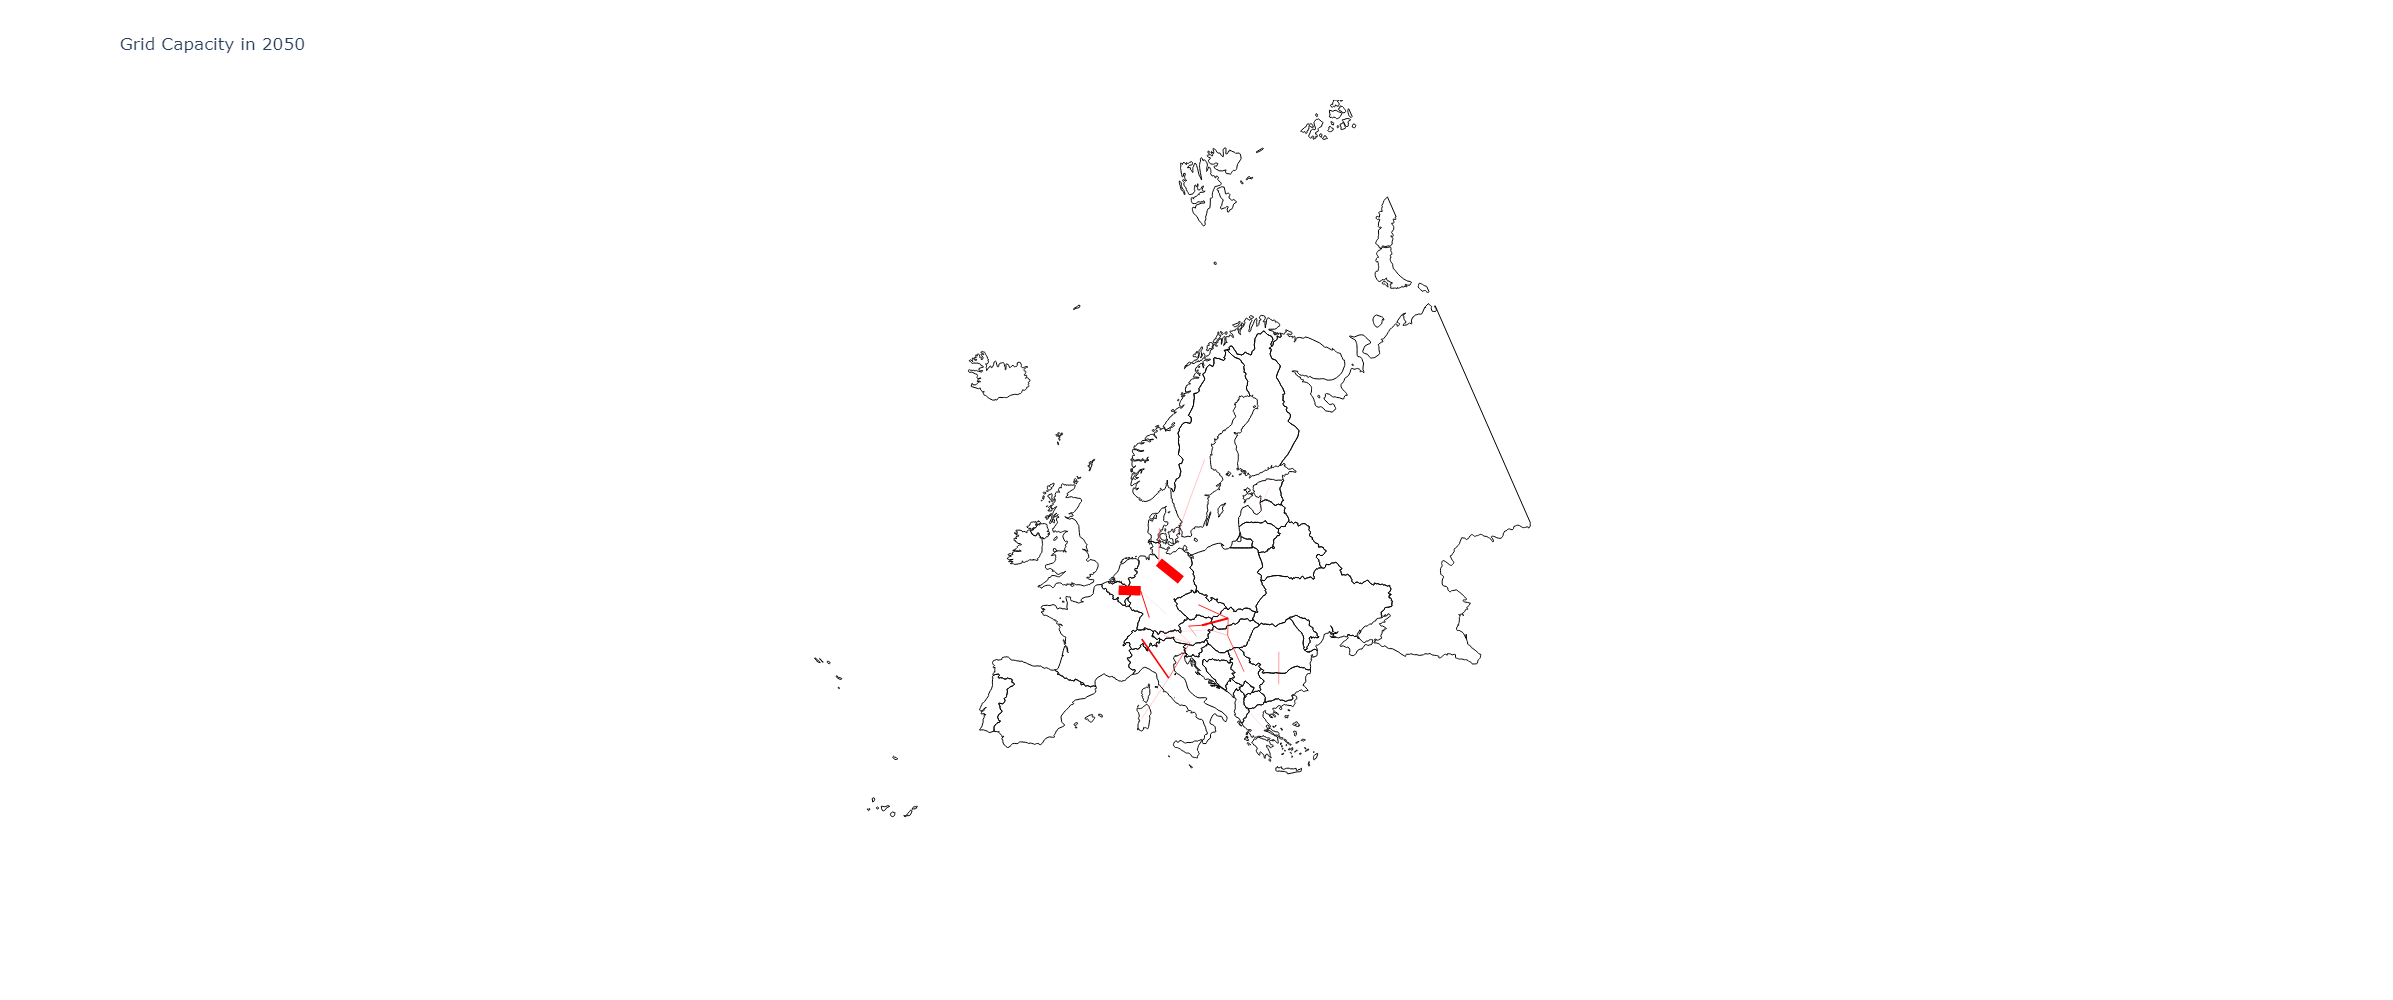

In [136]:
carrier = 'gas pipeline'
year = '2050'
normal, retro, dc = get_grid_df(n = networks['2050'], carrier = carrier)
carrier= carrier[:3].strip()          #this part is unnecessary here should be deleted as soon as get_grid_df is modified 
df = normal.buses[normal.buses.carrier == carrier].copy()
df['ct'] = df.index.str[:5]
divisor = 1e3

fig = go.Figure(data=go.Choropleth(
    #geojson=j_file,
    featureidkey= 'properties.COUNTRY_ID',
    locationmode='geojson-id', # honestly no idea what this does
    locations=df['ct'],
    z=df['v_nom'], # Placeholder Variable for a later use could be colorcode for powerussage?  
    autocolorscale=False,
    showscale=False,
    hoverinfo = 'text',
    text = df['ct']

))

#Plot grid lines and set width, AC has to be treated specially 
if carrier == 'AC':

    for i in range(len(normal.lines.s_nom_opt)):
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'geojson-id',# honestly no idea what this does
                lon = [df.loc[normal.lines.bus0[i]]['x'].round(3), df.loc[normal.lines.bus1[i]]['x'].round(3)],
                lat = [df.loc[normal.lines.bus0[i]]['y'].round(3), df.loc[normal.lines.bus1[i]]['y'].round(3)],
                mode = 'lines',
                line = dict(width = (normal.lines.s_nom_opt[i])/divisor,color = 'green'), #s_nom_opt nur Termische Kap = s_nom_opt * s_max_pu für net
                # opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),  => Could be used later
                name="{} GW AC-Grid".format(int(round(normal.lines.s_nom_opt[i])/divisor))
            )
        )
    for i in range(len(dc.links.p_nom_opt)):
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'geojson-id',# honestly no idea what this does
                lon = [df.loc[normal.links.bus0[i]]['x'].round(3), df.loc[normal.links.bus1[i]]['x'].round(3)],
                lat = [df.loc[normal.links.bus0[i]]['y'].round(3), df.loc[normal.links.bus1[i]]['y'].round(3)],
                mode = 'lines',
                line = dict(width = (dc.links.p_nom_opt[i])/divisor,color = 'red'),
                hoverinfo = 'text',
                text = dc.links.p_nom[i].round(0),
                # opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
                name="{} GW DC-Grid".format(int(round(dc.links.p_nom_opt[i])/divisor))
            )
        )

else:

    for i in range(len(normal.links.p_nom_opt)):
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'geojson-id',# honestly no idea what this does
                lon = [df.loc[normal.links.bus0[i]]['x'].round(3), df.loc[normal.links.bus1[i]]['x'].round(3)],
                lat = [df.loc[normal.links.bus0[i]]['y'].round(3), df.loc[normal.links.bus1[i]]['y'].round(3)],
                mode = 'lines',
                line = dict(width = (normal.links.p_nom_opt[i])/divisor,color = 'red'),
                # opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
                text = normal.links.p_nom[i],
                name="{} GW Pipeline".format(int(round(normal.links.p_nom_opt[i])/divisor))

            )
        )
    for i in range(len(retro.links.p_nom_opt)):
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'geojson-id',# honestly no idea what this does
                lon = [df.loc[retro.links.bus0[i]]['x'].round(3), df.loc[retro.links.bus1[i]]['x'].round(3)],
                lat = [df.loc[retro.links.bus0[i]]['y'].round(3), df.loc[retro.links.bus1[i]]['y'].round(3)],
                mode = 'lines',
                line = dict(width = (retro.links.p_nom_opt[i])/divisor,color = 'blue'),
                hoverinfo = 'text',
                text = retro.links.p_nom[i].round(0),
                name="{} GW retrofitted Pipeline".format(int(round(retro.links.p_nom_opt[i])/divisor))
                # opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
            )
        )

#centralize on europe
fig.update_geos(
    visible=False, resolution=50, 
    scope="europe",
    # center=dict(lon=11, lat=40),
    # projection_rotation=dict(lon=30, lat=30, roll=30),
    # lataxis_range=[10,11], lonaxis_range=[33,41],
    showcountries=True, countrycolor="Black",
    #showsubunits=True, subunitcolor="Blue"
)


#Scale Figure 
fig.update_layout(
    title=f" Grid Capacity in {year}",
    autosize=False,
    width=1000,
    height=1000,
    #showlegend = True,
    #hovermode='x unified',
    #legend=dict(itemsizing='constant')
)



labels_to_show_in_legend = []

for s in (10,3):
    if carrier == 'AC':
        a = int(round(min(dc.links.p_nom_opt/divisor, key=lambda x:abs(x-s))))
        labels_to_show_in_legend.append("{} GW DC-Grid".format(a))
        b = int(round(min(normal.lines.s_nom_opt/divisor, key=lambda x:abs(x-s))/s)*s)
        labels_to_show_in_legend.append("{} GW AC-Grid".format(b))
    elif carrier == 'gas pipeline':
        c = int(round(min(normal.links.p_nom_opt/divisor, key=lambda x:abs(x-s))/s)*s)
        labels_to_show_in_legend.append("{} GW Pipeline".format(c))
    else:
        c = int(round(min(normal.links.p_nom_opt/divisor, key=lambda x:abs(x-s))/s)*s)
        labels_to_show_in_legend.append("{} GW Pipeline".format(c))
        # d = int(round(min(retro.links.p_nom_opt/divisor, key=lambda x:abs(x-s))/s)*s)
        # labels_to_show_in_legend.append("{} GW retrofitted Pipeline".format(d))

labels = set()
    
for trace in fig['data']: 
    if ( not trace['name'] in labels) and (trace['name'] in labels_to_show_in_legend):
        labels.add(trace['name'])
        trace['showlegend'] = True
        print(trace['name'])
    else:
        trace['showlegend'] = False
            

fig.show()
# labels = []

# fig.update_traces(showlegend=False).add_trace(
#     [
   
#     go.Scattergeo(lon = [fig.data[0]], lat = [fig.data[0]],
#         mode = 'lines',
#         line = dict(width = (3 * 1e3 / divisor), color = 'blue'),
#         name=" 3 GW Grid Capacity",
#         showlegend=True
#     )
#     ]
# )

In [137]:
labels_to_show_in_legend

['10 GW Pipeline', '3 GW Pipeline']

In [143]:
for i in range(len(normal.links.p_nom_opt)):
    name="{} GW retrofitted Pipeline".format(int(round(normal.links.p_nom_opt[i])/divisor))
    print(name)

0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
2 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
9 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
1 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
9 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofitted Pipeline
0 GW retrofi

In [132]:
s = 10
int(round(min(normal.links.p_nom_opt/divisor, key=lambda x:abs(x-s))))

2

In [70]:
import math

labels = []
for s in (10,3):
    b = int(round(min(normal.lines.s_nom_opt/divisor, key=lambda x:abs(x-s))/s)*s)
    labels.append("{} AC GW".format(b))
    a = int(round(min(dc.links.p_nom_opt/divisor, key=lambda x:abs(x-s))))
    labels.append("{} DC GW".format(a))
#

labels

['10 AC GW', '8 DC GW', '3 AC GW', '3 DC GW']

In [20]:
def plot_grid(normal, retro, dc, carrier, year):
    """Plots a Geo. Figure in Plotly containing all clusters and a given grid
    Parameters
    ----------
    normal : Dataframe containing Links and Buses for AC and H2/gas grid, should be provided by get_grid_df funktion
    retro : Dataframe containing Links and Buses for retrofitted H2 grid, should be provided by get_grid_df funktion
    carrier : string (== "gas pipeline", "AC", "H2 pipeline")
        carrier (e.g. "gas pipeline", "AC") used to differenciate what grid to plot
    
    Returns
    -------
    Grid plot of a given carrier
    """
    carrier= carrier[:3].strip()          #this part is unnecessary here should be deleted as soon as get_grid_df is modified 
    df = normal.buses[normal.buses.carrier == carrier].copy()
    df['ct'] = df.index.str[:5]
    divisor = 1e3
    
    fig = go.Figure(data=go.Choropleth(
        #geojson=j_file,
        featureidkey= 'properties.COUNTRY_ID',
        locationmode='geojson-id', # honestly no idea what this does
        locations=df['ct'],
        z=df['v_nom'], # Placeholder Variable for a later use could be colorcode for powerussage?  
        autocolorscale=False,
        showscale=False,
        hoverinfo = 'text',
        text = df['ct']

    ))

    #Plot grid lines and set width, AC has to be treated specially 
    if carrier == 'AC':

        for i in range(len(normal.lines.s_nom_opt)):
            fig.add_trace(
                go.Scattergeo(
                    locationmode = 'geojson-id',# honestly no idea what this does
                    lon = [df.loc[normal.lines.bus0[i]]['x'].round(3), df.loc[normal.lines.bus1[i]]['x'].round(3)],
                    lat = [df.loc[normal.lines.bus0[i]]['y'].round(3), df.loc[normal.lines.bus1[i]]['y'].round(3)],
                    mode = 'lines',
                    line = dict(width = (normal.lines.s_nom_opt[i])/divisor,color = 'green'), #s_nom_opt nur Termische Kap = s_nom_opt * s_max_pu für net
                    # opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),  => Could be used later
                    name="AC Grid"
                )
            )
        for i in range(len(dc.links.p_nom_opt)):
            fig.add_trace(
                go.Scattergeo(
                    locationmode = 'geojson-id',# honestly no idea what this does
                    lon = [df.loc[retro.links.bus0[i]]['x'].round(3), df.loc[retro.links.bus1[i]]['x'].round(3)],
                    lat = [df.loc[retro.links.bus0[i]]['y'].round(3), df.loc[retro.links.bus1[i]]['y'].round(3)],
                    mode = 'lines',
                    line = dict(width = (dc.links.p_nom_opt[i])/divisor,color = 'red'),
                    hoverinfo = 'text',
                    text = dc.links.p_nom[i].round(0),
                    # opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
                    name="DC Grid"
                )
            )

    else:

        for i in range(len(normal.links.p_nom_opt)):
            fig.add_trace(
                go.Scattergeo(
                    locationmode = 'geojson-id',# honestly no idea what this does
                    lon = [df.loc[normal.links.bus0[i]]['x'].round(3), df.loc[normal.links.bus1[i]]['x'].round(3)],
                    lat = [df.loc[normal.links.bus0[i]]['y'].round(3), df.loc[normal.links.bus1[i]]['y'].round(3)],
                    mode = 'lines',
                    line = dict(width = (normal.links.p_nom_opt[i])/divisor,color = 'red'),
                    # opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
                    text = normal.links.p_nom[i],
                    name="new Pipeline"
                    
                )
            )
        for i in range(len(retro.links.p_nom_opt)):
            fig.add_trace(
                go.Scattergeo(
                    locationmode = 'geojson-id',# honestly no idea what this does
                    lon = [df.loc[retro.links.bus0[i]]['x'].round(3), df.loc[retro.links.bus1[i]]['x'].round(3)],
                    lat = [df.loc[retro.links.bus0[i]]['y'].round(3), df.loc[retro.links.bus1[i]]['y'].round(3)],
                    mode = 'lines',
                    line = dict(width = (retro.links.p_nom_opt[i])/divisor,color = 'blue'),
                    hoverinfo = 'text',
                    text = retro.links.p_nom[i].round(0),
                    name="retrofitted Pipeline"
                    # opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
                )
            )

    #centralize on europe
    fig.update_geos(
        visible=False, resolution=50, 
        scope="europe",
        # center=dict(lon=11, lat=40),
        # projection_rotation=dict(lon=30, lat=30, roll=30),
        # lataxis_range=[10,11], lonaxis_range=[33,41],
        showcountries=True, countrycolor="Black",
        #showsubunits=True, subunitcolor="Blue"
    )
    

    #Scale Figure 
    fig.update_layout(
        title=f" Grid Capacity in {year}",
        autosize=False,
        width=1000,
        height=1000,
        showlegend = True,
        #hovermode='x unified',
        legend=dict(itemsizing='constant')
    )
    names = set()
    fig.for_each_trace(
        lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))

    return(fig)

In [9]:
#pip install dash-bootstrap-components

In [18]:
from dash import Dash, dcc, Output, Input  # pip install dash
import dash_bootstrap_components as dbc    # pip install dash-bootstrap-components
import plotly.express as px

# incorporate data into app
#df = px.data.medals_long()

# Build your components
app = Dash(__name__, external_stylesheets=[dbc.themes.SOLAR])
mytitle = dcc.Markdown(children='# TEST TEST')
mygraph = dcc.Graph(figure={})
dropdown = dcc.Dropdown(options=['H2 pipeline', 'gas pipeline', "AC"],
                        value='H2 pipeline',  # initial value displayed when page first loads
                        clearable=False)
dropdown_year = dcc.Dropdown(options=['2015','2020','2030','2040','2050'],
                        value='2015',  # initial value displayed when page first loads
                        clearable=False)

# Customize your own Layout
app.layout = dbc.Container([mytitle, dropdown, dropdown_year, mygraph])

# Callback allows components to interact
@app.callback(
    Output(mygraph, component_property='figure'),
    Input(dropdown, component_property='value'),
    Input(dropdown_year, component_property='value')
)
def update_graph(user_input, dropdown_year):  # function arguments come from the component property of the Input
    carrier = user_input
    n = networks[dropdown_year]
    normal,retro,dc = get_grid_df(n,carrier)
    fig = plot_grid(normal, retro, dc, carrier, dropdown_year)
    return fig  # returned objects are assigned to the component property of the Output




In [21]:
# Run app
if __name__=='__main__':
    app.run_server( port=9993)

Dash is running on http://127.0.0.1:9993/

Dash is running on http://127.0.0.1:9993/



INFO:__main__:Dash is running on http://127.0.0.1:9993/



 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:9993
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [30/Jan/2023 13:13:26] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jan/2023 13:13:26] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_7_1m1671627520.12.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jan/2023 13:13:26] "GET /_dash-component-suites/dash/deps/react@16.v2_7_1m1671627520.14.0.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jan/2023 13:13:26] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_7_1m1671627520.14.0.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jan/2023 13:13:26] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_7_1m1671627520.8.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jan/2023 13:13:26] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap

## Sachen die noch fehlen:

1) Österreich richtig plotten
2) Legende
3) AC und DC addieren


In [13]:
handles = []
labels = []
line_factor = 1e3
for s in (10, 3): # these values define the legend, change for different scaling
    handles.append(plt.Line2D([0], [0], color="green",
                                linewidth=s * 1e3 / line_factor))
    labels.append("{} GW".format(s))

In [15]:
handles